In [35]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from imblearn.over_sampling import SMOTE
from collections import Counter

import librosa
from pydub import AudioSegment
from pydub.silence import split_on_silence


from sklearn.model_selection import GroupShuffleSplit, KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler



import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import SGD

import opensmile

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

import seaborn as sns
import torch

In [6]:
#print("Current directory:", os.getcwd())
#print("Directory contents:", os.listdir('.'))

from src.models import lstm, RandomForest
from src.data_loader import DataLoader

In [10]:
def one_hot_encoder(y):
    enc = OneHotEncoder(sparse_output=False)  
    return enc.fit_transform(y.reshape(-1, 1)) 


def normalization(X):
    scaler = StandardScaler()
    X_shape = X.shape
    if len(X_shape) == 3:
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = scaler.fit_transform(X_reshaped)
        X = X_scaled.reshape(X_shape[0], X_shape[1], X_shape[2])
        return X
    else:
        print("Debería ser dimenison 3")

def SMOTE_(X, y):
    x_shape = X.shape
    if len(x_shape) ==3:
        X = X.reshape((x_shape[0], -1))
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    if len(x_shape) == 3:
        X = X.reshape((-1, x_shape[1], x_shape[2]))
    return X, y


In [9]:
DL = DataLoader()



se inicializo


In [25]:
speech1_dataset_dev = "data/1part_Speech_dataset_dev.npy"
speech2_dataset_dev = "data/2part_Speech_dataset_dev.npy"
speech3_dataset_dev = "data/3part_Speech_dataset_dev.npy"
speech4_dataset_dev = "data/4part_Speech_dataset_dev.npy"
speech8_dataset_dev = "data/8part_Speech_dataset_dev.npy"
speech16_dataset_dev = "data/16part_Speech_dataset_dev.npy"
song1_dataset_dev = "data/1part_Song_dataset_dev.npy"
song2_dataset_dev = "data/2part_Song_dataset_dev.npy"
song3_dataset_dev = "data/3part_Song_dataset_dev.npy"
song4_dataset_dev = "data/4part_Song_dataset_dev.npy"
song8_dataset_dev = "data/8part_Song_dataset_dev.npy"
song16_dataset_dev = "data/16part_Song_dataset_dev.npy"

speech1_dataset_test = "data/1part_Speech_dataset_test.npy"
speech2_dataset_test = "data/2part_Speech_dataset_test.npy"
speech3_dataset_test = "data/3part_Speech_dataset_test.npy"
speech4_dataset_test = "data/4part_Speech_dataset_test.npy"
speech8_dataset_test = "data/8part_Speech_dataset_test.npy"
speech16_dataset_test = "data/16part_Speech_dataset_test.npy"
song1_dataset_test = "data/1part_Song_dataset_test.npy"
song2_dataset_test = "data/2part_Song_dataset_test.npy"
song3_dataset_test = "data/3part_Song_dataset_test.npy"
song4_dataset_test = "data/4part_Song_dataset_test.npy"
song8_dataset_test = "data/8part_Song_dataset_test.npy"
song16_dataset_test = "data/16part_Song_dataset_test.npy"

path_speech_dev = r"data\Audio_Speech_Actors_01-24\*\*"
path_song_dev = r"data\Audio_Song_Actors_01-24\*\*"
path_speech_test = r"data/data_test/speech/*/*"
path_song_test = r"data/data_test/song/*/*"


"data\Audio_Speech_Actors_01-24\Actor_09\03-01-04-01-01-01-09.wav"
r"data\Audio_Speech_Actors_01-24\Actor_09\03-01-02-01-02-01-09(1).wav"

'data\\Audio_Speech_Actors_01-24\\Actor_09\\03-01-02-01-02-01-09(1).wav'

In [ ]:
DL.process_dataset(path_song_dev, song16_dataset_dev, 16)
DL.process_dataset(path_speech_dev, speech16_dataset_dev, 16)
DL.process_dataset(path_song_test, song16_dataset_test, 16)
DL.process_dataset(path_speech_test, speech16_dataset_test, 16)



## RNN: LSTM

data/8part_Song_actors_dev.npy
X shape (1948, 8, 88)
y shape (1948,)
actors shape (1948,)
data/8part_Song_actors_test.npy
X shape (520, 8, 88)
y shape (520,)
actors shape (520,)
Distribución de clases antes de SMOTE train: Counter({3: 238, 2: 238, 6: 232, 5: 232, 4: 232, 8: 123, 7: 121, 1: 116})
Distribución de clases antes de SMOTE valid: Counter({3: 64, 4: 64, 5: 64, 2: 64, 6: 64, 8: 32, 7: 32, 1: 32})
Distribución de clases antes de SMOTE test: Counter({2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 1: 40, 7: 40, 8: 40})
Distribución de clases despues de SMOTE train: Counter({3: 238, 2: 238, 8: 238, 6: 238, 5: 238, 4: 238, 7: 238, 1: 238})
Distribución de clases despues de SMOTE train: Counter({3: 64, 4: 64, 5: 64, 2: 64, 6: 64, 8: 32, 7: 32, 1: 32})
Distribución de clases despues de SMOTE train: Counter({2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 1: 40, 7: 40, 8: 40})


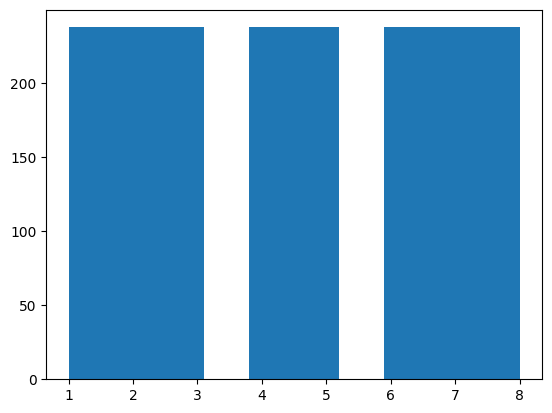

s
(1904, 8, 88)
(416, 8, 88)


In [36]:
X_dev, y_dev, actors_dev = DL.get_dataset([song8_dataset_dev, speech8_dataset_dev])
X_train, X_valid, y_train, y_valid, actors_train, actors_valid = DL.split_dataset(X_dev, y_dev, test_size=0.2, actors=actors_dev)
X_test, y_test, actors_test = DL.get_dataset([song8_dataset_test, speech8_dataset_test])

print('Distribución de clases antes de SMOTE train:', Counter(y_train))
print('Distribución de clases antes de SMOTE valid:', Counter(y_valid))
print('Distribución de clases antes de SMOTE test:', Counter(y_test))


X_train, y_train = SMOTE_(X_train, y_train)
#X_valid, y_valid = SMOTE_(X_valid, y_valid)
#X_test, y_test = SMOTE_(X_test, y_test)


print('Distribución de clases despues de SMOTE train:', Counter(y_train))
print('Distribución de clases despues de SMOTE train:', Counter(y_valid))
print('Distribución de clases despues de SMOTE train:', Counter(y_test))



plt.hist(y_train)
plt.show()


print("s")
print(X_train.shape)
print(X_valid.shape)

X_train = normalization(X_train)
X_valid = normalization(X_valid)
X_test = normalization(X_test)

y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)
y_dev_ohe = one_hot_encoder(y_dev)



In [88]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

class rnnLSTM():
    def __init__(self, X_train, y_train, lr = 0.001, patience = 3, dropout_rate = 0.5, momentum = 0.9):
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        self.model = Sequential()
        self.model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(Dropout(dropout_rate))
        self.model.add(LSTM(128, return_sequences=False))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(y_train.shape[1], activation='softmax'))
        self.model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_valid, y_valid, epochs=10, batch_size=32, random_seed=42):
        print("cambio")
        tf.random.set_seed(random_seed)
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[self.early_stopping])

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test)
        return test_loss, test_accuracy
    
    def plot_learning_curves(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        accuracy = history_dict['accuracy']
        val_accuracy = history_dict['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()


class rnnLSTM2():
    def __init__(self, X_train, y_train, lr=0.0001, patience=10, dropout_rate=0.6, lstm_units=128, optimizer_type='Adam'):
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience//2, min_lr=1e-6)
        
        self.model = Sequential()
        self.model.add(LSTM(lstm_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(Dropout(dropout_rate))
        self.model.add(LSTM(lstm_units, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(y_train.shape[1], activation='softmax'))
        
        if optimizer_type == 'Adam':
            optimizer = Adam(learning_rate=lr)
        else:
            optimizer = SGD(learning_rate=lr, momentum=0.9)
        
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_valid, y_valid, epochs=50, batch_size=32, random_seed=42):
        tf.random.set_seed(random_seed)
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[self.early_stopping, self.reduce_lr])

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test)
        return test_loss, test_accuracy

    def plot_learning_curves(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        accuracy = history_dict['accuracy']
        val_accuracy = history_dict['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()

class LSTM_Autoencoder_RNN:
    def __init__(self, input_shape, lstm_units=64, dropout_rate=0.3, latent_dim=44, optimizer_autoencoder=Adam(), optimizer_rnn=SGD(learning_rate=0.005, momentum=0.9), patience=3, num_classes=8):
        self.input_shape = input_shape
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.latent_dim = latent_dim
        self.optimizer_autoencoder = optimizer_autoencoder
        self.optimizer_rnn = optimizer_rnn
        self.patience = patience
        self.num_classes = num_classes

        # Build autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder()

        # Build RNN model
        self.rnn_model = self.build_rnn_model()
    
    def build_autoencoder(self):
        inputs = Input(shape=self.input_shape)
        
        # Encoder
        flat_inputs = TimeDistributed(Flatten())(inputs)
        encoded = TimeDistributed(Dense(self.latent_dim, activation='relu'))(flat_inputs)
        
        # Decoder
        decoded = TimeDistributed(Dense(np.prod(self.input_shape[1:]), activation='relu'))(encoded)
        decoded = TimeDistributed(Reshape(self.input_shape[1:]))(decoded)
        
        autoencoder = Model(inputs, decoded)
        autoencoder.compile(optimizer=self.optimizer_autoencoder, loss='mse')
        
        encoder = Model(inputs, encoded)
        
        return autoencoder, encoder
    
    def build_rnn_model(self):
        model = Sequential()
        model.add(LSTM(self.lstm_units, return_sequences=True, input_shape=(self.input_shape[0], self.latent_dim)))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(self.lstm_units, return_sequences=False))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(self.num_classes, activation='softmax'))  # Cambiar a softmax para clasificación multiclase
        model.compile(optimizer=self.optimizer_rnn, loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def train_autoencoder(self, X_train, X_valid, epochs=50, batch_size=32, verbose=1):
        self.autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, X_valid), verbose=verbose)
    
    def transform(self, X):
        return self.encoder.predict(X)
    
    def train_rnn(self, X_train, y_train, X_valid, y_valid, epochs=300, batch_size=32, verbose=1):
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
        self.history = self.rnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=verbose)
    
    def evaluate_rnn(self, X_test, y_test):
        return self.rnn_model.evaluate(X_test, y_test)
    
    def plot_learning_curves(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        accuracy = history_dict['accuracy']
        val_accuracy = history_dict['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()


Epoch 1/50
60/60 [==============================] - 1s 5ms/step - loss: 0.9974 - val_loss: 0.9089
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.8574 - val_loss: 0.8215
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.7878 - val_loss: 0.7675
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.7403 - val_loss: 0.7275
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.7075 - val_loss: 0.7017
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6833 - val_loss: 0.6829
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6658 - val_loss: 0.6682
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6503 - val_loss: 0.6539
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6378 - val_loss: 0.6438
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6275 - val_loss: 0.6353
Epoch 11/50
60/60 [

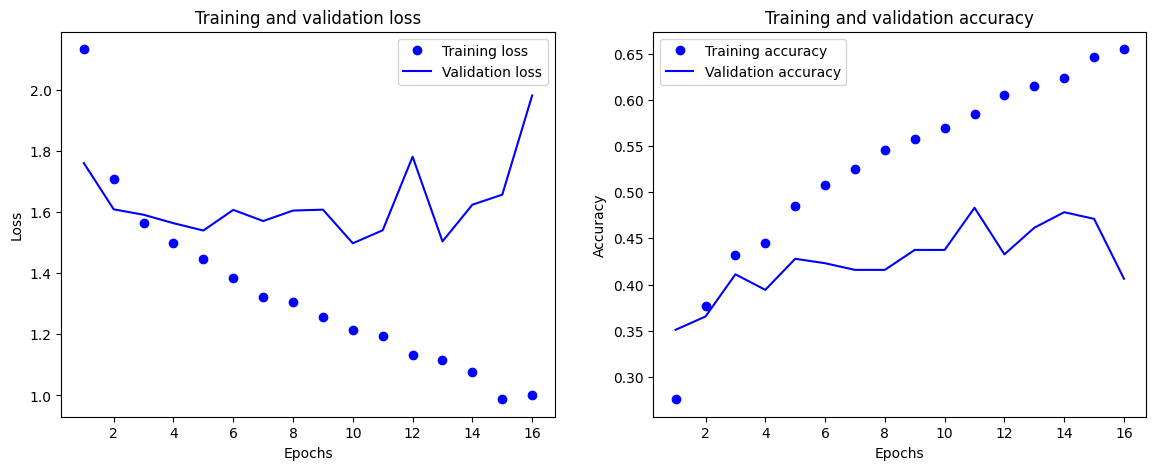

In [89]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_time_segments, features)
lstm_autoencoder_rnn = LSTM_Autoencoder_RNN(input_shape=input_shape)
lstm_autoencoder_rnn.train_autoencoder(X_train, X_valid)

X_train_encoded = lstm_autoencoder_rnn.transform(X_train)
X_valid_encoded = lstm_autoencoder_rnn.transform(X_valid)
X_test_encoded = lstm_autoencoder_rnn.transform(X_test)
print(X_train_encoded.shape)

lstm_autoencoder_rnn.train_rnn(X_train_encoded, y_train_ohe, X_valid_encoded, y_valid_ohe)
lstm_autoencoder_rnn.plot_learning_curves()


In [90]:
print("test")

test_loss, test_accuracy = lstm_autoencoder_rnn.evaluate_rnn(X_test_encoded, y_test_ohe)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

test
17/17 [==============================] - 1s 5ms/step - loss: 1.5844 - accuracy: 0.4346
Test loss: 1.5843521356582642, Test accuracy: 0.4346153736114502


### Cross validation: RNN

In [59]:

def cross_validate_rnn(X, y, groups, n_splits=5, epochs=100, batch_size=32, learning_rate = 0.001, dropout = 0.5, momentum =0.9):
    valid_loss = []
    gkf = GroupKFold(n_splits=n_splits)
    fold_no = 1
    print(y.shape)
    for train_index, val_index in gkf.split(X, y, groups):
        print(f'Training fold {fold_no} ...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        X_val, y_val = shuffle(X_val, y_val, random_state=42)

        print(y_train)
        print(X_train.shape)
        print(y_train.shape)
        print(X_val.shape)
        print(y_val.shape)
        model = lstm.rnnLSTM(X_train, y_train, lr= learning_rate, dropout_rate=dropout, momentum=momentum)
        model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

        val_loss, val_accuracy = model.evaluate(X_val, y_val)
        print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        valid_loss.append(val_loss)
        fold_no += 1
    return np.mean(valid_loss)



In [ ]:
batches_size = [32, 64]
lrs = [0.001, 0.01]
dropout = [0.2, 0.5]
momentum = [0.7, 0.9]

hyperparams = list(itertools.product(batches_size, lrs, dropout, momentum))
print(y_dev_ohe.shape)

valid_loss = []
for i in tqdm(range(len(hyperparams))):
    batch_s, lr, drop, moment = hyperparams[i]
    loss = cross_validate_rnn(X_dev, y_dev_ohe, actors_dev, batch_size=batch_s, learning_rate=lr, dropout=drop, momentum=moment)
    valid_loss.append(loss)


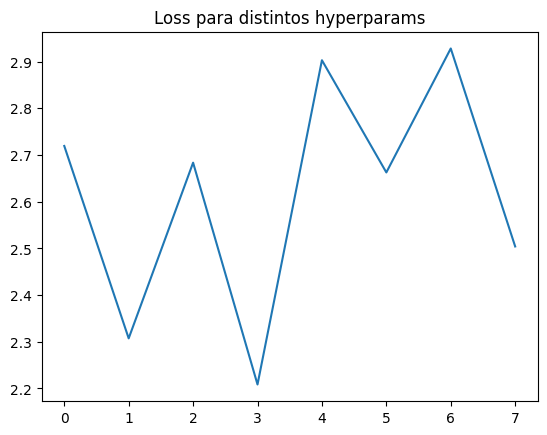

opt hyperparams:  (32, 0.001, 0.5, 0.9)
min val loss: 2.2084054946899414


In [66]:
plt.plot(range(len(valid_loss)), valid_loss)
plt.title("Loss para distintos hyperparams")
plt.show()

print("opt hyperparams: ", hyperparams[np.argmin(valid_loss)])
print("min val loss:", np.min(valid_loss))

In [13]:
RNN_hyperparams_save_path = "configs/data/RNN_hyperparameters.npy" 
np.save(RNN_hyperparams_save_path, hyperparams[np.argmin(valid_loss)])


train
cambio
Epoch 1/500
60/60 [==============================] - 4s 22ms/step - loss: 3.3439 - accuracy: 0.1297 - val_loss: 3.3142 - val_accuracy: 0.1875
Epoch 2/500
60/60 [==============================] - 1s 10ms/step - loss: 3.3020 - accuracy: 0.1560 - val_loss: 3.2764 - val_accuracy: 0.2404
Epoch 3/500
60/60 [==============================] - 1s 10ms/step - loss: 3.2655 - accuracy: 0.1518 - val_loss: 3.2390 - val_accuracy: 0.2764
Epoch 4/500
60/60 [==============================] - 1s 10ms/step - loss: 3.2299 - accuracy: 0.1738 - val_loss: 3.2020 - val_accuracy: 0.3462
Epoch 5/500
60/60 [==============================] - 1s 10ms/step - loss: 3.1952 - accuracy: 0.1838 - val_loss: 3.1650 - val_accuracy: 0.3630
Epoch 6/500
60/60 [==============================] - 1s 10ms/step - loss: 3.1554 - accuracy: 0.2195 - val_loss: 3.1278 - val_accuracy: 0.3678
Epoch 7/500
60/60 [==============================] - 1s 10ms/step - loss: 3.1142 - accuracy: 0.2437 - val_loss: 3.0891 - val_accuracy: 

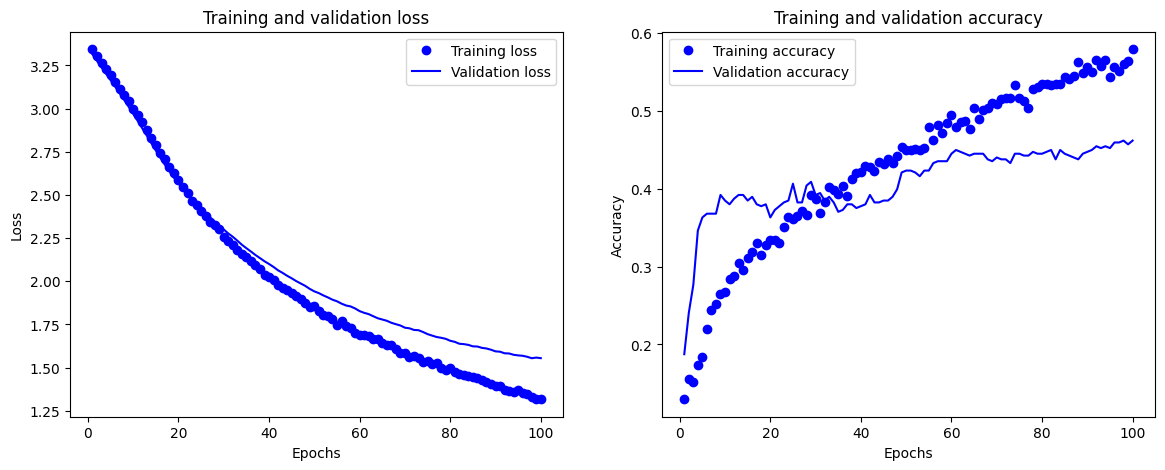

In [28]:
print("train")


#y_train_ohe  = one_hot_encoder(y_train)
#y_valid_ohe = one_hot_encoder(y_valid)
#y_test_ohe = one_hot_encoder(y_test)

#R = lstm.rnnLSTM(X_train, y_train_ohe, lr=0.001, dropout_rate=0.2, patience=2)
R = lstm.rnnLSTM(X_train, y_train_ohe, lr=0.001, dropout_rate=0.5, patience=2)
R.train(X_train, y_train_ohe, X_valid, y_valid_ohe, epochs=500, batch_size=32)
R.plot_learning_curves()

In [29]:
print("test")
test_loss, test_accuracy = R.evaluate(X_test, y_test_ohe)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

test
17/17 [==============================] - 1s 4ms/step - loss: 1.6055 - accuracy: 0.4712
Test Loss: 1.60551118850708
Test Accuracy: 0.4711538553237915


In [ ]:
classes_speech, classes_count_speech = np.unique(y_speech, return_counts=True)
classes_song, classes_count_song = np.unique(y_song, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

axs[0].bar(classes_speech, classes_count_speech)
axs[0].set_title('Speech dataset')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Cantidad de muestras')
axs[0].set_xticks(classes_speech) 

axs[1].bar(classes_song, classes_count_song)
axs[1].set_title('Song dataset')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Cantidad de muestras')
axs[1].set_xticks(classes_song)

plt.tight_layout()
plt.show()

#NOTE: There is no strong intensity for the 'neutral' emotion.

In [ ]:
print(np.unique(y_speech))
print(np.unique(y_song))

# y_speech = y_speech.astype(int)
# y_song = y_song.astype(int)

In [ ]:
scaler_speech = StandardScaler()
x_speech_scaled = scaler_speech.fit_transform(x_speech)

scaler_song = StandardScaler()
x_song_scaled = scaler_song.fit_transform(x_song)

pca_speech = PCA(n_components=2)
pca_speech_result = pca_speech.fit_transform(x_speech_scaled)
pca_speech_df = pd.DataFrame(data=pca_speech_result, columns=['PCA1', 'PCA2'])
pca_speech_df['Label'] = y_speech

pca_song = PCA(n_components=2)
pca_song_result = pca_song.fit_transform(x_song_scaled)
pca_song_df = pd.DataFrame(data=pca_song_result, columns=['PCA1', 'PCA2'])
pca_song_df['Label'] = y_song

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_speech_df, palette='viridis')
plt.title('PCA of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_song_df, palette='viridis')
plt.title('PCA of Song Features')
plt.legend(title='Emotion')
plt.show()

tsne_speech = TSNE(n_components=2, random_state=42)
tsne_speech_result = tsne_speech.fit_transform(x_speech_scaled)
tsne_speech_df = pd.DataFrame(data=tsne_speech_result, columns=['TSNE1', 'TSNE2'])
tsne_speech_df['Label'] = y_speech

tsne_song = TSNE(n_components=2, random_state=42)
tsne_song_result = tsne_song.fit_transform(x_song_scaled)
tsne_song_df = pd.DataFrame(data=tsne_song_result, columns=['TSNE1', 'TSNE2'])
tsne_song_df['Label'] = y_song

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_speech_df, palette='viridis')
plt.title('t-SNE of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_song_df, palette='viridis')
plt.title('t-SNE of Song Features')
plt.legend(title='Emotion')
plt.show()


## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [2]:
X_dev, y_dev, actors_dev = DL.get_dataset([speech1_dataset_dev, song1_dataset_dev])
X_train, X_valid, y_train, y_valid, actors_train, actors_valid = DL.split_dataset(X_dev, y_dev, test_size=0.2, actors=actors_dev)
X_test, y_test, actors_test = DL.get_dataset([speech1_dataset_test, song1_dataset_test])

plt.hist(y_train)
plt.show()

X_train, y_train = SMOTE_(X_train, y_train)
#X_valid, y_valid = SMOTE_(X_valid, y_valid)
#X_test, y_test = SMOTE_(X_test, y_test)


plt.hist(y_train)
plt.show()


print("s")
print(X_train.shape)
print(X_valid.shape)

# X_train = normalization(X_train)
# X_valid = normalization(X_valid)
# X_test = normalization(X_test)

y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)
y_dev_ohe = one_hot_encoder(y_dev)



NameError: name 'DL' is not defined

## Random Forest

In [123]:
class RandomForest_vl:
    def __init__(self, n_estimators=100, max_features='auto', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, bootstrap=True,
                 criterion='gini', random_state=42):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.random_state = random_state
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_features=self.max_features,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            bootstrap=self.bootstrap,
            criterion=self.criterion,
            random_state=self.random_state
        )

    def fit(self, X_train, y_train, X_valid, y_valid):
        X_train_shape = X_train.shape
        X_valid_shape = X_valid.shape
        if len(X_train_shape) == 3:
            X_train = X_train.reshape(-1, X_train_shape[-1])
            X_valid = X_valid.reshape(-1, X_valid_shape[-1])
        self.model.fit(X_train, y_train)
        val_predictions = self.model.predict(X_valid)
        #X_train = X_train.reshape(X_train_shape[0], X_train_shape[1], X_train_shape[2])
        #X_test = X_test.reshape(X_test_shape[0], X_test_shape[1], X_test_shape[2])
        acc = accuracy_score(y_valid, val_predictions)
        print(f"Validation Accuracy: {acc}")
        return acc



    def predict(self, X):
        X_shape = X.shape
        if len(X_shape) == 3:
            X = X.reshape(-1, X_shape[-1])
        return self.model.predict(X)


In [111]:


def cross_valid_RF(X, y, groups, num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion, n_splits=5):

    valid_acc = []
    gkf = GroupKFold(n_splits=n_splits)
    fold_no = 1
    print(y.shape)
    model = RandomForest.RandomForest(n_estimators=num_trees,
                             max_features=max_features,
                             max_depth=max_depth,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             bootstrap=bootstrap,
                             criterion=criterion)
    for train_index, val_index in gkf.split(X, y, groups):
        print(f'Training fold {fold_no} ...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        X_val, y_val = shuffle(X_val, y_val, random_state=42)

        acc = model.fit(X_train, y_train, X_val, y_val)

        #val_loss, val_accuracy = model.evaluate(X_val, y_val)
        #print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        valid_acc.append(acc)
        fold_no += 1
    return np.mean(valid_acc)


In [ ]:
# NO CORRER (es el cross validation)


num_trees = [100, 200, 300, 400, 500]
max_features = ['sqrt', 'log2']
max_depth = [5, 10, 20, 30, 40, 50, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 10]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

hyperparams = list(itertools.product(num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion))
hyperparams = np.array(hyperparams)
selected_indices = np.random.choice(len(hyperparams), 100, replace=False) # agarro 100 combinaciones random
selected_hyperparams = hyperparams[selected_indices]

valid_acc = []
for i in tqdm(range(len(selected_hyperparams))):
    print(selected_hyperparams[i])
    num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion = selected_hyperparams[i]
    acc = cross_valid_RF(X_dev, y_dev, actors_dev, num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion)
    valid_acc.append(acc)



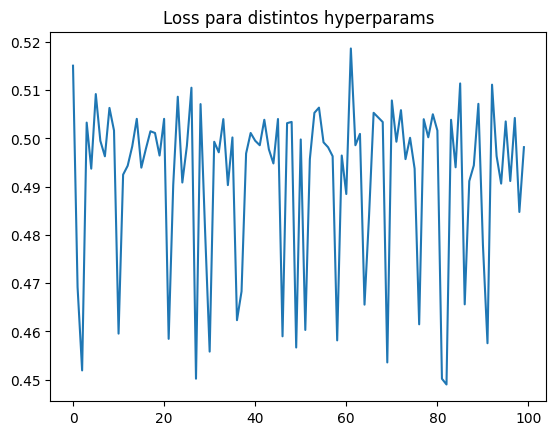

opt hyperparams:  [100 'sqrt' 10 10 2 True 'entropy']
max val acc: 0.5186477891430722


In [117]:
plt.plot(range(len(valid_acc)), valid_acc)
plt.title("Loss para distintos hyperparams")
plt.show()

RF_hyperparams_save_path = "configs/data/RF_hyperparameters.npy" 
np.save(RF_hyperparams_save_path, hyperparams[np.argmax(valid_acc)])
# se guarda los hiperparametros optimos calculados con CV. orden: num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion
print("opt hyperparams: ", hyperparams[np.argmax(valid_acc)])
print("max val acc:", np.max(valid_acc))


In [124]:
RF_hyperparams = np.load(RF_hyperparams_save_path, allow_pickle=True)


RF = RandomForest.RandomForest(n_estimators=RF_hyperparams[0],
                             max_features=RF_hyperparams[1],
                             max_depth=RF_hyperparams[2],
                             min_samples_split=RF_hyperparams[3],
                             min_samples_leaf=RF_hyperparams[4],
                             bootstrap=RF_hyperparams[5],
                             criterion=RF_hyperparams[6])

#X_shape_train = X_train.shape
#X_shape_test = X_test.shape

#if len(X_shape_train) ==3:
#    X_train = X_train.reshape(-1, X_shape_train[-1])
#    X_test = X_test.reshape(-1, X_shape_test[-1])
RF.fit(X_train, y_train, X_valid, y_valid)
#X_train = X_train.reshape(X_shape_train[0], X_shape_train[1], X_shape_train[2])
y_predict = RF.predict(X_test)
#X_test = X_test.reshape(X_shape_test[0], X_shape_test[1], X_shape_test[2])

acc = accuracy_score(y_test, y_predict)
print(f" trees --> test Accuracy {acc}")

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


Validation Accuracy: 0.49278846153846156
 trees --> test Accuracy 0.5076923076923077
Confusion Matrix:
[[20  6  4  0  0  0  6  4]
 [ 8 52  6  7  0  2  5  0]
 [ 3  4 35  3 14  1  6 14]
 [ 6 20 10 21  1  9  8  5]
 [ 0  0  3  0 56  0 10 11]
 [ 4  3 17  2 17 25  9  3]
 [ 0  2  0  0  1  4 29  4]
 [ 2  0  0  1  4  4  3 26]]

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.50      0.48        40
           2       0.60      0.65      0.62        80
           3       0.47      0.44      0.45        80
           4       0.62      0.26      0.37        80
           5       0.60      0.70      0.65        80
           6       0.56      0.31      0.40        80
           7       0.38      0.72      0.50        40
           8       0.39      0.65      0.49        40

    accuracy                           0.51       520
   macro avg       0.51      0.53      0.49       520
weighted avg       0.53      0.51      0.50       520



In [ ]:
class MLPAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(MLPAutoencoder, self).__init__()
        #self.flatten = nn.Flatten()
        self.encoder = nn.Linear(88, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 88)
        #self.unflatten = torch.nn.Unflatten(1, 88)

    def forward(self, x):
        #x = self.flatten(x)
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))
        return out
    
    def get_embedding(self, x):
        #x = self.flatten(x)
        return F.relu(self.encoder(x))
d = torch.from_numpy(x_train)
print(d.shape)
print(nn.Flatten(d))
print(d[0].shape)
print(d)
print(d.dtype)

In [ ]:
model = MLPAutoencoder(33).double()
pred = model(d)


In [ ]:
LR = 0.1
device = "cpu"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

n_epochs = 20
model.to(device)
t_losses, v_losses = [], []
x_train_tensor = torch.from_numpy(x_train_norm)
x_test_tensor = torch.from_numpy(x_test_norm)

for epoch in tqdm(range(1, n_epochs+1)):
    # Training
    train_loss = 0.0
    for (X, y) in zip(x_train_tensor, y_train):
        X = torch.squeeze(X).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    # Eval        
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (X, y) in zip(x_test_tensor, y_test):
            X = torch.squeeze(X).to(device)
            outputs = model(X)
            loss = criterion(outputs, X)
            test_loss += loss.item()        
            
    train_loss = train_loss/len(x_train)
    test_loss = test_loss/len(x_test)
    t_losses.append(train_loss)
    v_losses.append(test_loss)
    
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,len(t_losses)+1), t_losses, label='Train loss')
plt.plot(np.arange(1,len(v_losses)+1),v_losses, label='Validation loss')
plt.xticks(np.arange(1,len(t_losses)+1))
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Redes neuronales

## CNN

In [32]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_spectrogram(audio_path, sr=22050, n_mels=224, fmax=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

def save_spectrogram(spectrogram, save_path):
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_files(files, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for audio_path in files:
        filename = os.path.basename(audio_path)
        emotion_code = filename.split('-')[2] 
        emotion = emotion_labels.get(emotion_code, 'unknown')
        
        class_dir = os.path.join(output_path, emotion)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        spectrogram = extract_spectrogram(audio_path)
        save_path = os.path.join(class_dir, filename.replace('.wav', '.png'))
        save_spectrogram(spectrogram, save_path)

In [34]:
dev_path = "data/data_dev/speech/*/*.wav"
test_path = "data/data_test/speech/*/*.wav"

files = glob(dev_path)
output_path = "data/spectrograms/speech"
process_files(files, output_path)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 28 * 28, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 8)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

batch_size = 32
learning_rate = 0.001
momentum = 0.8
epochs = 20

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485], std=[0.229]),
])

dataset = datasets.ImageFolder(root=output_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# model = CNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)

# for epoch in range(epochs):
#     running_loss = 0.0
#     for i, data in enumerate(dataloader, 0):
#         inputs, labels = data
        
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 10 == 9:  
#             print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
#             running_loss = 0.0

model = CNN()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99: 
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

Finished Training


In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: False
CUDA is not available. Ensure that you have installed the correct drivers and CUDA version.


In [36]:
test_files = glob(test_path)
test_output_path = "data/spectrograms_test/speech"
process_files(test_files, test_output_path)

In [37]:
test_dataset = datasets.ImageFolder(root=test_output_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

with torch.no_grad():
    for inputs, _ in test_dataloader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        print(probabilities.numpy())

Accuracy: 13.333333333333334%
[[0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.102

In [ ]:
# torch.save(model.state_dict(), 'emotion_net.pth')

# model.load_state_dict(torch.load('emotion_net.pth'))
# model.eval()

# test_dataset = datasets.ImageFolder(root="pathdeltest", transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the test images: {100 * correct / total}%')


In [ ]:
# class CNN_X(Model):
#     def __init__(self):
#         super(CNN_X, self).__init__()
#         self.conv1 = Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1))
#         self.avgpool1 = AveragePooling2D(pool_size=(2, 2))
#         self.conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')
#         self.avgpool2 = AveragePooling2D(pool_size=(2, 2))
#         self.conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')
#         self.avgpool3 = AveragePooling2D(pool_size=(2, 2))
#         self.flatten = Flatten()
#         self.fc1 = Dense(2048, activation='relu')
#         self.fc2 = Dense(2048, activation='relu')
#         self.fc3 = Dense(8, activation='softmax')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.avgpool1(x)
#         x = self.conv2(x)
#         x = self.avgpool2(x)
#         x = self.conv3(x)
#         x = self.avgpool3(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return self.fc3(x)